# Monte Carlo LunarLander

Tabular Monte Carlo method to solve OpenAI GYM LunarLander-v2: https://gym.openai.com/envs/LunarLander-v2/

You can find more about this algorithm in Sutton's book Reinforcement Learning: An introduction (Chapter 5) http://incompleteideas.net/book/the-book-2nd.html

---

## Importing packages

In [1]:
import numpy as np
import gym
import random
import math

## Create the environment

In [2]:
def create_env():
    return gym.make('LunarLander-v2')
    #env.render()

## Environment preview

In [3]:
def env_preview(env):
    env.reset()
    for dummy in range(100):
        env.render()
        state, reward, done, info = env.step(env.action_space.sample())
        if done:
            break
    env.close()

## Understanding the environment

In [4]:
def show_action_and_env_space(env):
    # Action space and environment space
    print("env.action_space", env.action_space)
    print("env.observation_space", env.observation_space)
    print("env.observation_space.high", env.observation_space.high)
    print("env.observation_space.low", env.observation_space.low)

## Buckets
We need to discretize the environment values (observation vector); to do this, we are going to use buckets for each dimension of the observation vector. If the real value of the first dimension of the observation vector is in $[a,b]$ and if the number of buckets for that dimension is $n$, we are going to interpolate that real value into an integer in $[0,n-1]$.

In [5]:
def set_buckets_and_actions():
    number_of_buckets = (5,5,5,5,5,5,2,2) #buckets in each dimension
    number_of_actions = env.action_space.n
    
    #Creating a 2-tuple with the original bounds of each dimension
    state_value_bounds = list(zip(env.observation_space.low,env.observation_space.high))
    
    #New bound values for each dimension
    state_value_bounds[0] = [-1,1]      #Position x
    state_value_bounds[1] = [-1,1]    #Position y
    state_value_bounds[2] = [-1,1]        #vel x
    state_value_bounds[3] = [-1,1]    #vel y
    state_value_bounds[4] = [-1,1]        #angle
    state_value_bounds[5] = [-1,1]        #angular vel
    state_value_bounds[6] = [0,1]
    state_value_bounds[7] = [0,1]
    
    return number_of_buckets, number_of_actions, state_value_bounds
    
    

In [6]:
def bucketize(state):
    bucket_indexes = []
    for i in range(len(state)):
        if state[i] <= state_value_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_value_bounds[i][1]:
            bucket_index = number_of_buckets[i] - 1
        else:
            bound_width = state_value_bounds[i][1] - state_value_bounds[i][0]
            offset = (number_of_buckets[i]-1) * state_value_bounds[i][0]/bound_width
            scaling = (number_of_buckets[i]-1) / bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indexes.append(bucket_index)
    return tuple(bucket_indexes)

## Create the Q-table

In [7]:
def initialize_q_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

## Create Returns_table

In [8]:
def initialize_visits_table():
    return np.zeros(number_of_buckets + (number_of_actions,))

In [9]:
def decay_function(episode):
    return max(min_epsilon, min(max_epsilon, 1.0 - 
                              math.log10((episode + 1) / (total_train_episodes*0.1))))

In [10]:
def choose_action(q_table, bucket_state, epsilon):
    if (np.random.random() <= epsilon):
        #print("random")
        return env.action_space.sample() #Exploration
    else:
        #print("greedy")
        return np.argmax(q_table[bucket_state]) #Eplotation

In [11]:
# ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
def Generate_episode(epsilon, q_table, max_env_steps):
    # Control variables
    total_reward = 0
    done = False
        
    trayectory = []
        
    # Initialize S
    # Reset the environment getting the initial state
    bucket_state = bucketize(env.reset())

    # Loop for each step of episode:
    for step in range(max_env_steps):
            #print("step ", step)

        # Choose A from S using a soft policy derived from Q (e.g., epsilon-greedy)
        action = choose_action(q_table, bucket_state, epsilon)
            #print(q_table[bucket_state])
            #print("action ", action)

        # Take the action A, observe R, S'
        new_state, reward, done, info = env.step(action)
        bucket_new_state = bucketize(new_state)
            #print("reward ", reward)
            
        trayectory.append([bucket_state, action, reward])
            
        # new_state is now the current state
        bucket_state = bucket_new_state

        total_reward += reward

        # if done, finish the episode
        if done:
            break
    
    return trayectory, total_reward

---

# The Monte Carlo algorithm

* Initialize $Q(s,a) \in \mathbb{R}$ arbitrarily ($Q(S,A) = 0$, for all $S,A$ in this case)
* $Returns(s,a) \longleftarrow$ empty list for all $S, A$
* Loop for each episode:
    * Generate an episode following $\pi$: $S_0, A_0, R_1, ..., S_{T-1}, A_{T-1}, R_T$
    * $G \longleftarrow 0$
    * Loop for each step of episode, $t=T-1, T-2, ..., 0$:
        * $G \longleftarrow \gamma G + R_{t+1}$
        * Unless the pair $S_t, A_t$ appears in $S_0, A_0, S_1, A_1, ..., S_{t-1}, A_{t-1}$:
            * Append $G$ to $Returns(S_t,A_t)$
            * $Q(S_t,A_t)$ $\longleftarrow$ average($Returns(S_t,A_t)$)
            * $A* \longleftarrow argmax_aQ(S_t,a)$
            * For all $a \in A(S_t)$:
                * if $a = A*: \pi (a|S_t) \longleftarrow 1 - \epsilon + \epsilon / A(S_t)$
                * else if $a \neq A*: \pi (a|S_t) \longleftarrow \epsilon / A(S_t)$
                

In [12]:
def Monte_Carlo():
    # ******* Initialize 𝑄(s,a) arbitrarily.
    q_table = initialize_q_table()
    #print("Q_Table shape: ", q_table.shape)
    
    # ******* Initialize Returns(s,a) empty list
    # initialize visits_counter instead (for incremental implementation of the average)
    visits_counter = initialize_visits_table()
    
    rewards = []
    
    max_env_steps = env._max_episode_steps   #1000 in LunarLander
    #print("Max env steps: ", max_env_steps)
    

    
    # ******* Loop for each episode:
    for episode in range(total_train_episodes):
        #print("\n\n ***Episode*** ", episode)
        
        # ******* Generate an episode following pi: S0, A0, R1, ...S_T-1,A_T-1,R_T
        #Update epsilon
        epsilon = decay_function(episode)
        #print("Epsilon ", epsilon)
        trayectory ,total_reward = Generate_episode(epsilon, q_table, max_env_steps)
        
        # ******* G <-- 0
        G = 0
        
        
        # ******* Loop for each step of episode: t = T-1, T-2, ..., 0
        for t in reversed(range(len(trayectory))):
            #print("\n step", t)
            s_t, a_t, r_t = trayectory[t]
            # ******* G <-- gamma*G + R_{t+1}
            G = gamma*G + r_t
            #print("G ", G)
            
            # ******* Unless the pair S_t,A_t appears in S_0,A_0,R_1, ...,S_{t-1},A_{t-1}: 
            if not [s_t, a_t] in [[x[0], x[1]] for x in trayectory[0:t]]:
                #print("YES First visit ", s_t, a_t)
                
                # ******* Append G to Returns(S_t,A_t)
                # ******* Q(S_t,A_t) <-- average(Returns(S_t,A_t))
                # Using incremental implementation: Q(S_t,A_t)= Q_n <-- Q_n + (1/n)*(G_n - Q_n)
                visits_counter[s_t][a_t] += 1
                #print("visits_counter ", visits_counter[s_t][a_t])
                #print("old Q value ", q_table[s_t][a_t])
                q_table[s_t][a_t] += (G - q_table[s_t][a_t]) / visits_counter[s_t][a_t]
                #print("new Q value ", q_table[s_t][a_t])
            #else: print("NO first visit ", s_t, a_t)
        
                  
        #print("total_reward ", total_reward)
        
        if episode % 50 == 0:
            rewards.append(total_reward)
            print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))  
    
    rewards.append(total_reward)
    print("Episode {}, epsilon {:5.4f}, reward {:6.2f}".format(episode,epsilon,total_reward))
    return q_table, rewards

---

## Getting Q-Learning training plots 

#### Running Q-Learning algorithm n times

In [13]:
n_times = 5
total_train_episodes = 10000
gamma = 0.99                     
max_epsilon = 1.0
min_epsilon = 0.01   

env = create_env()
#env_preview(env)
#show_action_and_env_space(env)
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

MC_tables = []
MC_rewards = []

for number in range(n_times):
    print("\n ********** Training number ", number)
    q_table,rewards = Monte_Carlo()
    MC_tables.append(q_table)
    MC_rewards.append(rewards)


 ********** Training number  0
Episode 0, epsilon 1.0000, reward -307.04
Episode 50, epsilon 1.0000, reward -105.38
Episode 100, epsilon 1.0000, reward -216.17
Episode 150, epsilon 1.0000, reward -74.78
Episode 200, epsilon 1.0000, reward -314.44
Episode 250, epsilon 1.0000, reward -78.98
Episode 300, epsilon 1.0000, reward -409.97
Episode 350, epsilon 1.0000, reward -194.68
Episode 400, epsilon 1.0000, reward -179.34
Episode 450, epsilon 1.0000, reward  17.19
Episode 500, epsilon 1.0000, reward -32.74
Episode 550, epsilon 1.0000, reward -113.13
Episode 600, epsilon 1.0000, reward -169.69
Episode 650, epsilon 1.0000, reward -76.08
Episode 700, epsilon 1.0000, reward -420.09
Episode 750, epsilon 1.0000, reward -360.87
Episode 800, epsilon 1.0000, reward -168.35
Episode 850, epsilon 1.0000, reward -282.12
Episode 900, epsilon 1.0000, reward -118.21
Episode 950, epsilon 1.0000, reward -118.17
Episode 1000, epsilon 0.9996, reward -180.42
Episode 1050, epsilon 0.9784, reward -85.91
Episode

Episode 9250, epsilon 0.0338, reward 212.09
Episode 9300, epsilon 0.0315, reward 242.16
Episode 9350, epsilon 0.0291, reward 224.84
Episode 9400, epsilon 0.0268, reward 253.36
Episode 9450, epsilon 0.0245, reward  -9.22
Episode 9500, epsilon 0.0222, reward 244.80
Episode 9550, epsilon 0.0200, reward 269.80
Episode 9600, epsilon 0.0177, reward  -4.96
Episode 9650, epsilon 0.0154, reward 223.59
Episode 9700, epsilon 0.0132, reward 289.52
Episode 9750, epsilon 0.0110, reward 297.78
Episode 9800, epsilon 0.0100, reward 246.65
Episode 9850, epsilon 0.0100, reward 150.87
Episode 9900, epsilon 0.0100, reward 188.62
Episode 9950, epsilon 0.0100, reward 286.72
Episode 9999, epsilon 0.0100, reward  -1.58

 ********** Training number  1
Episode 0, epsilon 1.0000, reward -242.30
Episode 50, epsilon 1.0000, reward -164.40
Episode 100, epsilon 1.0000, reward -70.03
Episode 150, epsilon 1.0000, reward -270.08
Episode 200, epsilon 1.0000, reward -359.66
Episode 250, epsilon 1.0000, reward -154.19
Epis

Episode 8500, epsilon 0.0705, reward   5.63
Episode 8550, epsilon 0.0680, reward  13.92
Episode 8600, epsilon 0.0655, reward -33.79
Episode 8650, epsilon 0.0629, reward -23.61
Episode 8700, epsilon 0.0604, reward 244.19
Episode 8750, epsilon 0.0579, reward  -6.79
Episode 8800, epsilon 0.0555, reward -29.52
Episode 8850, epsilon 0.0530, reward  27.89
Episode 8900, epsilon 0.0506, reward  29.13
Episode 8950, epsilon 0.0481, reward  16.66
Episode 9000, epsilon 0.0457, reward -51.14
Episode 9050, epsilon 0.0433, reward   6.97
Episode 9100, epsilon 0.0409, reward 232.90
Episode 9150, epsilon 0.0385, reward -111.93
Episode 9200, epsilon 0.0362, reward  21.08
Episode 9250, epsilon 0.0338, reward -36.93
Episode 9300, epsilon 0.0315, reward  16.30
Episode 9350, epsilon 0.0291, reward  21.92
Episode 9400, epsilon 0.0268, reward  25.05
Episode 9450, epsilon 0.0245, reward  31.62
Episode 9500, epsilon 0.0222, reward  26.57
Episode 9550, epsilon 0.0200, reward  33.40
Episode 9600, epsilon 0.0177, r

Episode 7750, epsilon 0.1106, reward  46.99
Episode 7800, epsilon 0.1078, reward 252.80
Episode 7850, epsilon 0.1051, reward -93.87
Episode 7900, epsilon 0.1023, reward -17.74
Episode 7950, epsilon 0.0996, reward  27.68
Episode 8000, epsilon 0.0969, reward 125.68
Episode 8050, epsilon 0.0942, reward  20.59
Episode 8100, epsilon 0.0915, reward 242.59
Episode 8150, epsilon 0.0888, reward  -9.62
Episode 8200, epsilon 0.0861, reward 203.07
Episode 8250, epsilon 0.0835, reward  19.48
Episode 8300, epsilon 0.0809, reward  -1.82
Episode 8350, epsilon 0.0783, reward  19.50
Episode 8400, epsilon 0.0757, reward -20.92
Episode 8450, epsilon 0.0731, reward -26.98
Episode 8500, epsilon 0.0705, reward -95.37
Episode 8550, epsilon 0.0680, reward -42.79
Episode 8600, epsilon 0.0655, reward 209.06
Episode 8650, epsilon 0.0629, reward  -3.93
Episode 8700, epsilon 0.0604, reward -25.77
Episode 8750, epsilon 0.0579, reward 191.03
Episode 8800, epsilon 0.0555, reward 238.60
Episode 8850, epsilon 0.0530, re

Episode 6950, epsilon 0.1580, reward -45.25
Episode 7000, epsilon 0.1548, reward  48.13
Episode 7050, epsilon 0.1517, reward -25.37
Episode 7100, epsilon 0.1487, reward -52.29
Episode 7150, epsilon 0.1456, reward 192.63
Episode 7200, epsilon 0.1426, reward  35.58
Episode 7250, epsilon 0.1396, reward  74.56
Episode 7300, epsilon 0.1366, reward   9.51
Episode 7350, epsilon 0.1337, reward -257.69
Episode 7400, epsilon 0.1307, reward -25.45
Episode 7450, epsilon 0.1278, reward 157.54
Episode 7500, epsilon 0.1249, reward 158.98
Episode 7550, epsilon 0.1220, reward -49.72
Episode 7600, epsilon 0.1191, reward 151.61
Episode 7650, epsilon 0.1163, reward 146.96
Episode 7700, epsilon 0.1135, reward -53.90
Episode 7750, epsilon 0.1106, reward -23.71
Episode 7800, epsilon 0.1078, reward 228.97
Episode 7850, epsilon 0.1051, reward  19.32
Episode 7900, epsilon 0.1023, reward  38.40
Episode 7950, epsilon 0.0996, reward -119.22
Episode 8000, epsilon 0.0969, reward 163.55
Episode 8050, epsilon 0.0942, 

Episode 6200, epsilon 0.2075, reward -42.33
Episode 6250, epsilon 0.2041, reward -26.13
Episode 6300, epsilon 0.2006, reward   3.67
Episode 6350, epsilon 0.1972, reward  -9.86
Episode 6400, epsilon 0.1938, reward -23.80
Episode 6450, epsilon 0.1904, reward  -5.92
Episode 6500, epsilon 0.1870, reward -41.25
Episode 6550, epsilon 0.1837, reward -23.01
Episode 6600, epsilon 0.1804, reward -56.68
Episode 6650, epsilon 0.1771, reward -21.83
Episode 6700, epsilon 0.1739, reward -18.67
Episode 6750, epsilon 0.1706, reward  30.59
Episode 6800, epsilon 0.1674, reward  -8.51
Episode 6850, epsilon 0.1642, reward -36.59
Episode 6900, epsilon 0.1611, reward  19.39
Episode 6950, epsilon 0.1580, reward -46.41
Episode 7000, epsilon 0.1548, reward  47.69
Episode 7050, epsilon 0.1517, reward -50.12
Episode 7100, epsilon 0.1487, reward  24.51
Episode 7150, epsilon 0.1456, reward -82.68
Episode 7200, epsilon 0.1426, reward  53.49
Episode 7250, epsilon 0.1396, reward -32.42
Episode 7300, epsilon 0.1366, re

#### Saving average reward and Q-tables

In [14]:
MC_mean = np.mean(np.array(MC_rewards),axis=0)
#print(MC_mean.shape)
np.save('MC_mean', MC_mean)
np.save('MC_tables', MC_tables)

#### Plotting Q-Learning rewards

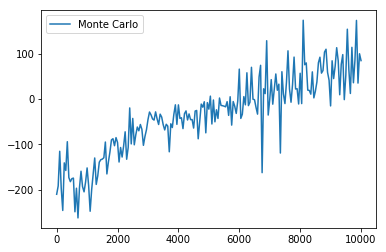

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

x = np.linspace(0, total_train_episodes, MC_mean.size)
plt.plot(x, MC_mean, label='Monte Carlo')

# Add a legend
plt.legend()

# Show the plot
plt.show()

---

# Testing


#### Testing Q(s,·) values for a given initial state s

In [17]:
#env = create_env()
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]

number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()
bucket_state = bucketize(env.reset())

print("State ", bucket_state)
print("Q(s,·) ", q_table[bucket_state])

State  (2, 4, 3, 3, 2, 2, 0, 0)
Q(s,·)  [-46.15959409 -21.25496133 -44.52908797 -49.35687673]


#### Testing LunarLander with the learned Q-Table

In [18]:
#env = create_env()
total_test_episodes = 10
q_tables = np.load('MC_tables.npy')
q_table = q_tables[0]
rewards = []
max_env_steps = env._max_episode_steps
number_of_buckets, number_of_actions, state_value_bounds = set_buckets_and_actions()

# ******* Loop for each episode:
for episode in range(total_test_episodes):
    #print("***Episode*** ", episode)
    
    # Control variables
    total_rewards = 0
    done =  False
    
    # ******* Initialize S
    # Reset the environment getting the initial state
    bucket_state = bucketize(env.reset())
    
    # *******Loop for each step of episode:
    for step in range(max_env_steps):
        env.render()
        
        #******* Choose A from S using policy derived from Q (greedy in this case)
        action = np.argmax(q_table[bucket_state])
        #print(action)
        
        # ******* Take the action A, observe R, S'
        new_state, reward, done, info = env.step(action)
        bucket_new_state = bucketize(new_state)
        
        # new_state is now the current state
        bucket_state =  bucket_new_state
        
        total_rewards += reward
        
        if done:
            rewards.append(total_rewards)
            print("Score ", total_rewards)
            break
                
env.close()
print("\nAverage score " + str(sum(rewards)/total_test_episodes))

Score  -130.04434967846996
Score  263.1832594923769
Score  -35.38586349921573
Score  -26.58173671514035
Score  175.67293461255667
Score  -321.72136296741445
Score  -27.262075919377367
Score  218.37341111487225
Score  15.450789741070821
Score  0.3165793666875203

Average score13.200158554794632
